<a href="https://colab.research.google.com/github/Barabaika/rna-cite-compit2022/blob/main/mmscel_multiome2_cv_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is about ?

Modeling for multiome part 

### About CV scheme

Public and private test sets are quite different. (Private - contains new DAY (and donor), while public ONLY new donor).
So one should be careful with the validation schemes.
Some proposals are described here: 

Notebook: https://www.kaggle.com/code/alexandervc/mmscel-crossvalidation-schemes
Topic: https://www.kaggle.com/competitions/open-problems-multimodal/discussion/358860

We will be based on them. 


### Versions

#### 3-** Modeling

#### 2 Prepare dim-reduced targets  

    save them to disk and only load later - do not need to calculate PCA on each fold again . 


#### 1 Starting 

    Looked for optimal TruncSVD for Y - 40 (r2) or 45 (mse)  

    Looked for optimal n_features = 110
    With Ridge with score on reduced Y seems the following params are good: 
    n_features_loc = 110# n_features # Found to be local max for pca on full Y (leaky)
    # 0.17980, 66.123 r2_score,mean_squared_error oof_private_like Full sample 





In [1]:
!pip install colorama
!pip install tensorflow-addons
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.5 MB/s 
     |████████████████████████████████| 1.6 MB 30.3 MB/s 


In [2]:
%%time
import time
import datetime
t0start = time.time()
print(datetime.datetime.now())

import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
#plt.style.use('dark_background')
import seaborn as sns

#If you see a urllib warning running this cell, go to "Settings" on the right hand side, 
#and turn on internet. Note, you need to be phone verified.
!pip install --quiet tables


if 0:
    import h5py
    !pip install hdf5plugin~=2.0 # https://forum.hdfgroup.org/t/cant-open-directory-usr-local-hdf5-lib-plugin/9738/4
    import hdf5plugin

    # !pip install scanpy
    # import scanpy as sc
    # import anndata

    DATA_DIR = "/kaggle/input/open-problems-multimodal/"
    FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

    FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
    FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
    FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

    FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
    FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
    FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

    FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
    FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

    df_cell = pd.read_csv(FP_CELL_METADATA)
    display(df_cell)

2022-11-15 19:10:36.352225
CPU times: user 556 ms, sys: 72.3 ms, total: 628 ms
Wall time: 4.46 s


In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, LayerNormalization, Layer, MultiHeadAttention, Reshape, Attention, Conv1D, \
    MaxPool1D, Dropout, BatchNormalization, Flatten, AveragePooling1D, Multiply

import tensorflow_addons as tfa
from tensorflow_addons.layers import WeightNormalization, AdaptiveAveragePooling1D

from tensorflow.keras.utils import plot_model
import keras_tuner
from sklearn.model_selection import StratifiedKFold

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

!mkdir /root/.kaggle
!cp /content/gdrive/MyDrive/kaggle/kaggle.json /root/.kaggle


!mkdir data
!unzip /content/gdrive/MyDrive/kaggle/metadata.csv.zip -d data
!unzip /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip -d data


!kaggle datasets download -d stasborodynkin/feature-shop-for-mmscel-multiome
!kaggle datasets download -d alexandervc/multiome-part-multimodal-singlecell-integration

!unzip -q feature-shop-for-mmscel-multiome.zip -d data
!unzip -q multiome-part-multimodal-singlecell-integration.zip -d data

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/kaggle/metadata.csv.zip
  inflating: data/metadata.csv       
Archive:  /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip
  inflating: data/train_cite_targets.h5  
100% 3.47G/3.49G [00:26<00:00, 142MB/s]
100% 3.49G/3.49G [00:26<00:00, 141MB/s]
 96% 262M/272M [00:02<00:00, 106MB/s]
100% 272M/272M [00:02<00:00, 108MB/s]


# Load and start prepare some metadata (cut only CITE-seq train part)

In [5]:
%%time
fn = 'data/_multiome_meta_all_text_also.csv'
df_meta_full = pd.read_csv(fn,index_col = 0)
print("df_meta_full['Train0_Test1'].value_counts()")
print(df_meta_full['Train0_Test1'].value_counts())
df_meta= df_meta_full[df_meta_full['Train0_Test1']==0].copy()
print("df_meta['day'].value_counts()")
print(df_meta['day'].value_counts())
print()
df_meta_full

df_meta_full['Train0_Test1'].value_counts()
0    105942
1     55935
Name: Train0_Test1, dtype: int64
df_meta['day'].value_counts()
4    31134
3    28815
2    23911
7    22082
Name: day, dtype: int64

CPU times: user 128 ms, sys: 42.9 ms, total: 171 ms
Wall time: 239 ms


,Train0_Test1,day,donor,cell_type
cell_id,,,,
56390cf1b95e,0,2,32606,NeuP
fc0c60183c33,0,2,32606,HSC
9b4a87e22ad0,0,2,32606,MasP
81cccad8cd81,0,2,32606,HSC
15cb3d85c232,0,2,32606,MkP
...,...,...,...,...
96a60b026659,1,10,31800,hidden
d493e546991e,1,10,31800,hidden
05666c99aa48,1,10,31800,hidden


# Preparations of targets PCA (should run once and save for later reuse) 

    # Results save here : https://www.kaggle.com/datasets/alexandervc/multiome-part-multimodal-singlecell-integration
    


In [6]:
%%time

if 0: # Should run once 
    
    # Results save here : https://www.kaggle.com/datasets/alexandervc/multiome-part-multimodal-singlecell-integration
    #Wall time: 1min 29s
    print('Load targets ')
    df_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS)
    print(df_train_y.shape)
    print('RAM Gigs consumed: ', df_train_y.memory_usage().sum()/1e9)
    display(df_train_y)


    from sklearn.decomposition import TruncatedSVD
    str_reducer_name = 'TSVD'
    import pickle
    import gc

    verbose = 100
    n_components_reducer1_for_targets = 45


    reducer1_for_targets = TruncatedSVD(n_components=n_components_reducer1_for_targets, random_state=42)

    t0 = time.time();datetime_object = datetime.datetime.now()
    print('Starts. ', datetime_object, ' df_train_y.shape:',  df_train_y.shape, '\n' )# ,'n_submit_samples', n_submit_samples )

    # To calculate score we need to compare with Y_true, but on each fold with have different dimensional reduction
    # So we make "OOF"-like from all these separate reductions. 
    Y_reduced_oof_true_private_like = np.zeros( (len(df_train_y), n_components_reducer1_for_targets  )  )
    for fold, indices_tuple  in enumerate( list_folds_indices ):
        t00 = time.time()
        train_index = indices_tuple[0]
        reducer1_for_targets.fit(df_train_y.values[train_index] )
        Y_reduced = reducer1_for_targets.transform(df_train_y.values)
        pd.DataFrame(Y_reduced).to_csv('Y_reduced_fold'+str(fold)+str_reducer_name+str(n_components_reducer1_for_targets)+'.csv')
        print(Y_reduced[:3,:3] )
        filename = 'dimreducer_save_fold'+str(fold)+str_reducer_name+str(n_components_reducer1_for_targets)+'.sav'
        pickle.dump(reducer1_for_targets, open(filename, 'wb'))
        # To load:
        # loaded_model = pickle.load(open(filename, 'rb'))

        # Calculate predictions for test-private-like
        i_loc = 1
        indices_loc = indices_tuple[i_loc] # Private-like test
        Y_reduced_oof_true_private_like[indices_loc ] += Y_reduced[indices_loc] * 0.5   # 0.5 - comes from the fact that our "quasi-folds" have intersection OOF parts - which correspond to "DAYs"

        gc.collect()
        if verbose >= 100:
            print('Finished fold:',fold, 'Train time:%.2f'%(time.time()-t00 ), 'len(train):',len(train_index))

        #break

    pd.DataFrame(Y_reduced_oof_true_private_like).to_csv('Y_reduced_oof_true_private_like_'+str_reducer_name+str(n_components_reducer1_for_targets)+'.csv')
    gc.collect()    

    # [[220.95189    -2.0739403  -9.507679 ]
    #  [194.00992    49.97837   -12.347744 ]
    #  [204.3097      1.2018498   1.863967 ]]
    # Finished fold: 0 Train time:66.13 len(train): 55594
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[221.1047     -5.8726883  -8.903437 ]
    #  [195.82693    39.968487   -5.6386395]
    #  [204.7528     -2.6942801   2.5685198]]
    # Finished fold: 1 Train time:65.60 len(train): 52275
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[221.80908    6.916283 -18.268188]
    #  [197.81242   73.03593   -8.832146]
    #  [205.4745     9.990948 -14.660288]]
    # Finished fold: 2 Train time:62.94 len(train): 51970
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[221.8454    -6.486882 -14.652436]
    #  [199.89952  -60.998592  18.813795]
    #  [205.88423   -6.261623  -5.708635]]
    # Finished fold: 3 Train time:61.91 len(train): 51588
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[221.79276     3.535838  -14.851676 ]
    #  [199.42273    71.43662   -10.366265 ]
    #  [205.72374     7.5578527 -13.918904 ]]
    # Finished fold: 4 Train time:63.06 len(train): 52040
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[221.8583      3.6416354 -14.074665 ]
    #  [201.09775    61.289116   14.704324 ]
    #  [206.00154     4.6480203  -6.42798  ]]
    # Finished fold: 5 Train time:62.95 len(train): 48757
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[221.96582     5.233857  -10.032437 ]
    #  [199.2937     78.22846    -3.4446604]
    #  [205.61676    15.873075  -12.867033 ]]
    # Finished fold: 6 Train time:69.43 len(train): 57119
    # /opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
    #   f"X has feature names, but {self.__class__.__name__} was fitted without"
    # [[222.04831    4.210063  -9.896264]
    #  [200.5755    77.08151   -9.473841]
    #  [205.90843   13.553973 -12.364328]]
    # Finished fold: 7 Train time:65.34 len(train): 54671
    # CPU times: user 22min, sys: 1min 19s, total: 23min 19s
    # Wall time: 8min 37s    

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


# Load prepared dime-reduced targets 

In [7]:
%%time
import pickle

dn = 'data/multiome_Y_reduction45tsvd/' 

dict_df_Y_reduced = {}
dict_reducer_fitted = {}

for fold in range(8):
    fn = dn + 'Y_reduced_fold'+str(fold)+'TSVD45.csv'
    dict_df_Y_reduced[fold] = pd.read_csv(fn,index_col = 0)
    print(dict_df_Y_reduced[fold].shape)
    filename = dn + 'dimreducer_save_fold'+str(fold)+'TSVD45.sav'
    dict_reducer_fitted[fold] = pickle.load(open(filename, 'rb'))
    
Y_reduced_oof_true_private_like = pd.read_csv(dn + 'Y_reduced_oof_true_private_like_TSVD45.csv' ,index_col = 0 )
print(Y_reduced_oof_true_private_like.shape)
print(Y_reduced_oof_true_private_like.iloc[:3,:3])

(105942, 45)
(105942, 45)
(105942, 45)
(105942, 45)
(105942, 45)
(105942, 45)
(105942, 45)
(105942, 45)
(105942, 45)
            0          1         2
0  221.028297  -3.973314 -9.205558
1  194.918427  44.973429 -8.993192
2  204.531250  -0.746215  2.216243
CPU times: user 6.49 s, sys: 538 ms, total: 7.02 s
Wall time: 7.15 s


In [8]:
print(dict_df_Y_reduced.keys() )
dict_reducer_fitted , 

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


({0: TruncatedSVD(n_components=45, random_state=42),
  1: TruncatedSVD(n_components=45, random_state=42),
  2: TruncatedSVD(n_components=45, random_state=42),
  3: TruncatedSVD(n_components=45, random_state=42),
  4: TruncatedSVD(n_components=45, random_state=42),
  5: TruncatedSVD(n_components=45, random_state=42),
  6: TruncatedSVD(n_components=45, random_state=42),
  7: TruncatedSVD(n_components=45, random_state=42)},)

# Load prepared Features 

In [9]:
%%time
#fn = '/kaggle/input/feature-shop-for-multimodal-singlecell-competition/citeseq_train_and_test_PCA200.csv'
#data_suffix = 'TruncatedSVD200_niter7_rs42'
data_suffix = 'tSVD_500'
#data_suffix = 'PCA500'
# data_suffix = 'PCA200'
fn = 'data/multiome_'+data_suffix+'.csv'
# fn = 'data/multiome_train_and_test_'+data_suffix+'.csv'

df_X = pd.read_csv(fn, index_col = 0)

print(df_X.shape,df_X.info())
print('RAM Gigs consumed: ', df_X.memory_usage().sum()/1e9)

display(df_X)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 161877 entries, 0 to 55934
Columns: 500 entries, 0 to 499
dtypes: float64(500)
memory usage: 618.7 MB
(161877, 500) None
RAM Gigs consumed:  0.648803016


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,38.695652,-10.995312,3.508682,8.051441,-1.210438,-0.591423,-4.384275,0.806714,-0.288749,0.070899,...,0.830129,0.087731,-0.169964,-3.689771,-0.164271,-2.389336,0.161847,0.803438,-1.293607,2.209294
1,30.671955,-1.192652,-4.129556,-3.601299,0.519070,-3.731482,2.730631,-1.078988,1.455982,2.588007,...,0.098360,0.498628,0.659521,-0.340139,-1.851978,0.190812,0.035555,1.157217,-0.078230,-0.548884
2,37.069910,-3.831173,4.178007,1.899280,-2.652614,2.376571,-5.418380,-0.047880,-1.326479,1.322428,...,-0.179565,1.470913,1.948770,2.416460,0.477109,-0.022122,0.108392,-1.263599,0.460198,0.708148
3,37.819900,-6.103211,-4.435801,-1.489536,-0.729872,1.189627,-1.571884,2.685926,-0.644127,0.465646,...,1.254042,0.057626,0.439364,0.518331,1.626862,-1.798571,1.102802,-0.833465,1.682420,0.646519
4,36.213314,3.623979,-3.542390,-4.007278,-0.515980,3.039861,-4.419027,-1.686895,-1.149320,1.732787,...,0.815563,0.847429,-0.205420,-0.881806,0.421107,-1.494466,-0.402348,-1.304086,1.049010,0.069787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55930,17.962160,-5.506730,1.434487,5.657413,3.011768,5.844456,7.024112,-0.944368,-1.111177,-0.491096,...,-0.153818,0.730354,-0.607482,0.450151,-0.774894,0.241063,0.335602,-0.547704,1.071098,0.008360
55931,35.466663,-1.526738,10.124527,2.243087,-1.643897,-3.379845,-1.992100,0.562841,0.803413,4.859437,...,0.184185,-0.246282,0.271271,-0.555041,0.467564,-0.161957,0.511120,0.056655,-0.131008,-0.417944
55932,38.540947,-11.313991,2.125688,3.413831,-4.067761,-4.364755,-4.604687,-3.275881,-2.784840,-1.863870,...,-0.086459,-0.653940,-0.189942,0.021816,-0.215020,0.421760,0.285205,0.746308,-0.540162,-0.360240
55933,45.655964,-15.950400,-0.053753,9.373517,-0.894323,-2.106717,-1.243296,-0.564487,3.056634,-1.878720,...,-0.235269,-0.302736,-0.718369,-0.420760,-0.409463,0.406691,-0.226399,-0.046806,-0.063934,-0.490391


CPU times: user 13.1 s, sys: 1.37 s, total: 14.5 s
Wall time: 14.5 s


# KEY Preparation of the specific cross-validation like scheme

In [10]:
%%time
print('Preparations')
print(df_meta['donor'].unique() ) 
print(df_meta['day'].unique() ) 
print(df_meta['day'].value_counts())
print(df_meta['cell_type'].value_counts())

df_meta['Index'] = range(df_meta.shape[0])
scol = 'donor&day&CT'
df_meta[scol] =df_meta['donor'].apply(lambda x:str(x)+'_') + df_meta['day'].apply(lambda x:str(x)+'_') + df_meta['cell_type']
print(); print('Look on least populated classes:')
print(df_meta[scol].value_counts().tail(4))
print()
if 1: # in order train test STRATIFY to work we need to avoid classes with just 1 representative
    mask_tmp =  df_meta[scol] == '13176_7_BP' # Only 1 such repersentative 
    print(mask_tmp.sum() )
    df_meta.loc[mask_tmp, scol] = '13176_7_MoP'
#df_meta[scol].value_counts()
df_meta.head(1)


Preparations
[32606 13176 31800]
[2 3 4 7]
4    31134
3    28815
2    23911
7    22082
Name: day, dtype: int64
HSC     34661
NeuP    21561
EryP    17135
MasP    16737
MkP     13221
MoP      2061
BP        566
Name: cell_type, dtype: int64

Look on least populated classes:
13176_3_BP    26
32606_3_BP    20
32606_7_BP    14
13176_7_BP     1
Name: donor&day&CT, dtype: int64

1
CPU times: user 115 ms, sys: 12 ms, total: 127 ms
Wall time: 127 ms


,Train0_Test1,day,donor,cell_type,Index,donor&day&CT
cell_id,,,,,,
56390cf1b95e,0,2,32606,NeuP,0,32606_2_NeuP


In [11]:
%%time

train_size_loc = 1# 0.87#0.86 # 0.3 # from 0 to 1 # To create diversity we have an option to train on subsets. 
random_seed4folds = 2# 446 # If train_size_loc < 1 - that controls the random seed to create subset of train part where we will actually train the model
verbose = 1000

from sklearn.model_selection import train_test_split

list_folds_indices_loc = []


# df_folds = pd.DataFrame(index = df_meta.index)
# df_folds['Index'] = range(df_folds.shape[0])


scol = 'donor&day&CT'
if train_size_loc < 1:
    IX_main, IX_complementary = train_test_split(df_meta['Index'].values, 
                         train_size = train_size_loc,  random_state= random_seed4folds,  
                         stratify = df_meta[scol] ,  shuffle=True )
else:
    IX_main = np.arange(df_meta.shape[0] ) # Everything will be included 
    IX_complementary = np.array([])

mask_train_main = (df_meta['Index'].isin( IX_main) )
print('mask_train_main.sum', mask_train_main.sum() )
c = 0
for day2exclude in [2,3,4, 7 ]: # Day to be excluded from the TRAIN , it defines the test-private-like  
    for donor2exclude in [32606,  31800]: # We will need to predict always MALE (not female) - like on LB. (# donor 13176 - female)
        train_index =\
            np.where(mask_train_main &  (df_meta['day']  != day2exclude) & ( df_meta['donor']  != donor2exclude  ) )  [0]
        test_index1_like_private_lb =\
            np.where(   (df_meta['day']  == day2exclude)  ) [0]
        test_index2_like_public_lb =\
            np.where( (df_meta['day']  != day2exclude) &  (df_meta['donor']  == donor2exclude ) ) [0]

        list_folds_indices_loc.append( (train_index,  test_index1_like_private_lb , test_index2_like_public_lb ) )
        
        
        if verbose >= 100:
            str_fold_inf = 'Fold ' +str(c) + ': Train: excludes Day '+str(day2exclude) + ' and Donor ' + str( donor2exclude )
            print(str_fold_inf, 'Sizes: train:',len(train_index), 'Test Like Priv'  ,len(test_index1_like_private_lb), 
                  'Test Like Publ',   len(test_index2_like_public_lb),  
                 ); 
            print('First 3 indices from each type:', train_index[:3],test_index1_like_private_lb[:3], test_index2_like_public_lb[:3]  )
        c+=1        
        
list_folds_indices = list_folds_indices_loc.copy()        

mask_train_main.sum 105942
Fold 0: Train: excludes Day 2 and Donor 32606 Sizes: train: 55594 Test Like Priv 23911 Test Like Publ 26437
First 3 indices from each type: [43259 43260 43261] [0 1 2] [7264 7265 7266]
Fold 1: Train: excludes Day 2 and Donor 31800 Sizes: train: 52275 Test Like Priv 23911 Test Like Publ 29756
First 3 indices from each type: [7264 7265 7266] [0 1 2] [76186 76187 76188]
Fold 2: Train: excludes Day 3 and Donor 32606 Sizes: train: 51970 Test Like Priv 28815 Test Like Publ 25157
First 3 indices from each type: [33701 33702 33703] [7264 7265 7266] [0 1 2]
Fold 3: Train: excludes Day 3 and Donor 31800 Sizes: train: 51588 Test Like Priv 28815 Test Like Publ 25539
First 3 indices from each type: [0 1 2] [7264 7265 7266] [69097 69098 69099]
Fold 4: Train: excludes Day 4 and Donor 32606 Sizes: train: 52040 Test Like Priv 31134 Test Like Publ 22768
First 3 indices from each type: [33701 33702 33703] [15808 15809 15810] [0 1 2]
Fold 5: Train: excludes Day 4 and Donor 31800

In [12]:
import gc
gc.collect()

44

# Set the model

In [13]:
X = df_X.values

In [14]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernels):
        super(ConvBlock, self).__init__()
        filters1, filters2, filters3 = filters
        kernel_size1, kernel_size2, kernel_size3 = kernels

        self.dropout = Dropout(0.1)
        
        self.conv2a = WeightNormalization(Conv1D(filters1, kernel_size = kernel_size1, padding='same'), data_init=False)
        self.bn2a = BatchNormalization() # axis=1

        self.conv2b = WeightNormalization(Conv1D(filters2, kernel_size = kernel_size2, padding='same'), data_init=False)
        self.bn2b = BatchNormalization()

        self.conv2c = WeightNormalization(Conv1D(filters3, kernel_size = kernel_size3, padding='same'), data_init=False)
        self.bn2c = BatchNormalization() # axis=1

    def call(self, input_tensor, training=False):
        
        x = self.bn2a(input_tensor, training=training)
        x = self.dropout(x)
        x = self.conv2a(x)
#         x = tf.nn.relu(x)

        x = self.bn2b(x, training=training)
        x = self.dropout(x)
        x = self.conv2b(x)
#         x = tf.nn.relu(x)

        x = self.bn2c(x, training=training)
        x = self.dropout(x)
        x = self.conv2c(x)

        return tf.nn.relu(x)

class ResnetBlock(tf.keras.Model):
    def __init__(self, filters, kernels):
        super(ResnetBlock, self).__init__()
        filters1, filters2, filters3 = filters
        kernel_size1, kernel_size2, kernel_size3 = kernels

        self.dropout = Dropout(0.1)
        
        self.conv2a = WeightNormalization(Conv1D(filters1, kernel_size = kernel_size1, padding='same'), data_init=False)
        self.bn2a = BatchNormalization() # axis=1

        self.conv2b = WeightNormalization(Conv1D(filters2, kernel_size = kernel_size2, padding='same'), data_init=False)
        self.bn2b = BatchNormalization()

        self.conv2c = WeightNormalization(Conv1D(filters3, kernel_size = kernel_size3, padding='same'), data_init=False)
        self.bn2c = BatchNormalization() # axis=1

    def call(self, input_tensor, training=False):
        
        x = self.bn2a(input_tensor, training=training)
        x = self.dropout(x)
        x = self.conv2a(x)
#         x = tf.nn.relu(x)

        x = self.bn2b(x, training=training)
        x = self.dropout(x)
        x = self.conv2b(x)
#         x = tf.nn.relu(x)

        x = self.bn2c(x, training=training)
        x = self.dropout(x)
        x = self.conv2c(x)

        x += input_tensor
        return tf.nn.relu(x)

class ResneXtBlock(tf.keras.Model):
    def __init__(self, filters,  kernels = [1,1,3,1]):
        super(ResneXtBlock, self).__init__()
        
        filter1, filter2, filter3 = filters
        kernel0, kernel1, kernel2, kernel3 = kernels

        self.dropout = Dropout(0.1)
        self.conv1 = WeightNormalization(Conv1D(filter3, kernel_size = kernel0, padding='same'), data_init=False)
        
        self.conv2a = WeightNormalization(Conv1D(filter1, kernel_size = kernel1, padding='same'), data_init=False)
        self.bn2a = BatchNormalization(axis=1)

        self.conv2b = WeightNormalization(Conv1D(filter2, kernel_size = kernel2, padding='same'), data_init=False)
        self.bn2b = BatchNormalization(axis=1)

        self.conv2c = WeightNormalization(Conv1D(filter3, kernel_size = kernel3, padding='same'), data_init=False)
        self.bn2c = BatchNormalization(axis=1)

    def call(self, input_tensor, training=False):
        
        x = self.bn2a(input_tensor, training=training)
        x = self.dropout(x)
        x = self.conv2a(x)
#         x = tf.nn.relu(x)

        x = self.bn2b(x, training=training)
        x = self.dropout(x)
        x = self.conv2b(x)
#         x = tf.nn.relu(x)

        x = self.bn2c(x, training=training)
        x = self.dropout(x)
        x = self.conv2c(x)
        
        input_tensor = self.conv1(input_tensor)

        x += input_tensor
        return tf.nn.relu(x)



In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [21]:
R2_score = tfa.metrics.r_square.RSquare()

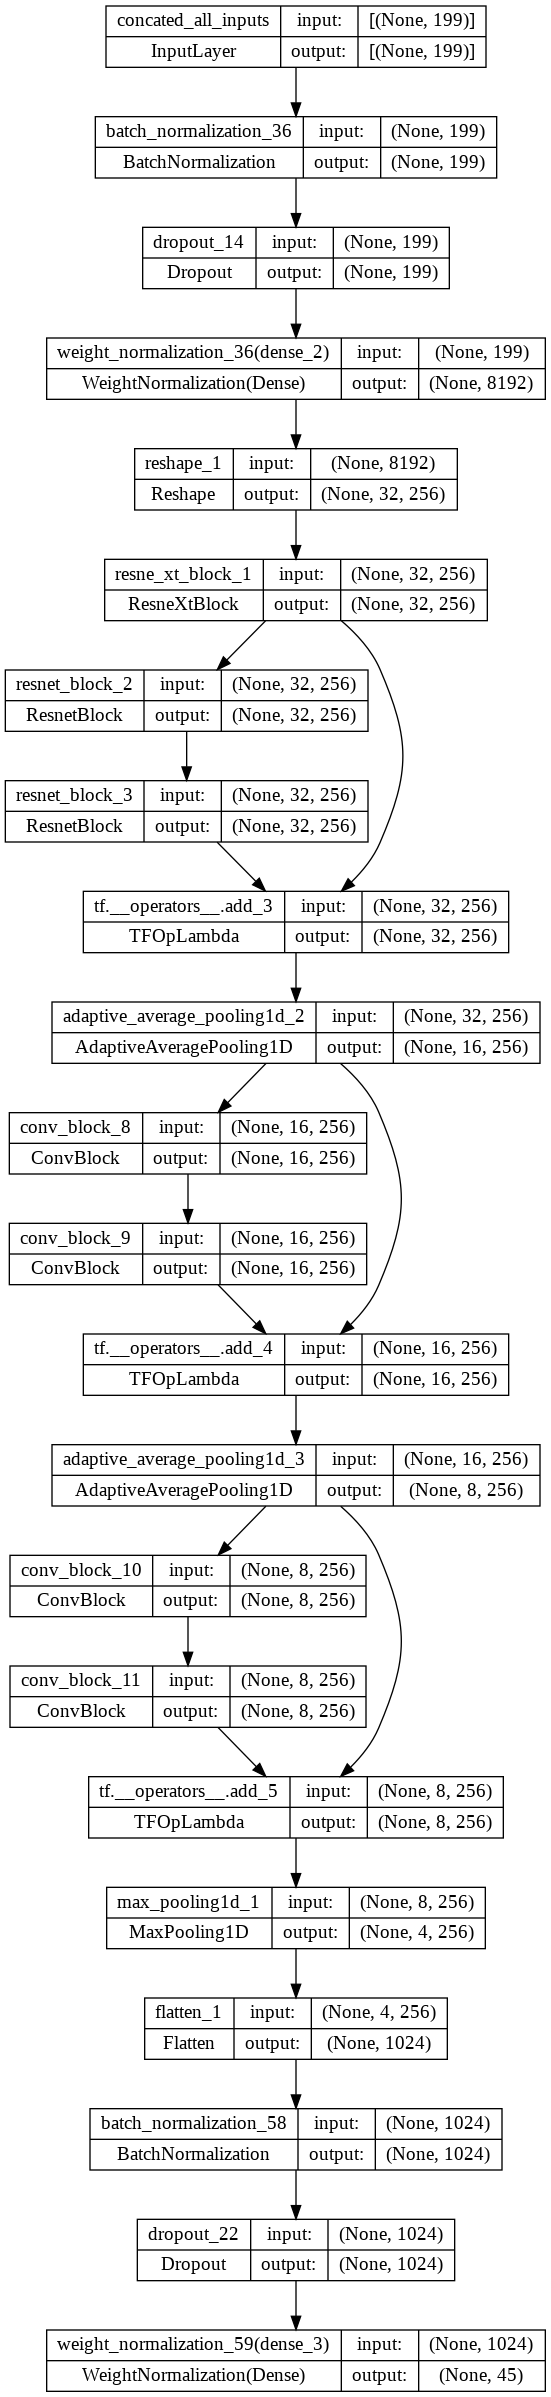

In [29]:
LR_START = 0.01
BATCH_SIZE = 256
# model like resnet from https://www.researchgate.net/figure/The-architecture-of-ResNet-50-vd-a-Stem-block-b-Stage1-Block1-c-Stage1-Block2_fig4_349646156
def my_model(hp, n_inputs = 199, n_targets = 45):    
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation_first = hp.Choice('activation_first', ["swish",'relu', 'gelu', 'elu'])
    # activation = hp.Choice('activation_other', ["swish",'celu', 'gelu'])
    
#     reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
#     important_genes_input = Input(shape=(n_inputs_imp_genes, ), name="important_genes")
#     dim_reduced_genes_input = Input(shape=(n_inputs_dim_red, ), name = "dim_reduced_genes")
#     connect_genes_input = Input(shape=(n_inputs_connect, ), name = "connect_genes")
    
#     x = Concatenate()([important_genes_input, dim_reduced_genes_input, connect_genes_input])
    inp = Input(shape=(n_inputs, ), name="concated_all_inputs")
    num_targets = n_targets

    hidden_size = hp.Choice('hidden_size', [2048, 4096, 8192], default = 8192)
    
    
    cha_1 = hp.Choice('flatten_to_channels', [128, 256, 512], default = 256)
    
    cha_2_1 = hp.Choice('channels2_1', [64, 128, 256, 512], default = 64)
    cha_2_2 = hp.Choice('channels2_2', [64, 128, 256, 512], default = 64)
    cha_2_3 = hp.Choice('channels2_3', [128, 256, 512], default = 256)
    
    cha_3_1 = hp.Choice('channels3_1', [64, 128, 256, 512], default = 64)
    cha_3_2 = hp.Choice('channels3_2', [64, 128, 256, 512], default = 64)
#     cha_3_3 = hp.Choice('channels_3', [128, 256, 512], default = 256)
    
    cha_4_1 = hp.Choice('channels4_1', [64, 128, 256, 512], default = 64)
    cha_4_2 = hp.Choice('channels4_2', [64, 128, 256, 512], default = 64)

    # activation_first = 'elu'
    # hidden_size = 8192
    # cha_1 =  128
    # cha_2_1 = 64
    # cha_2_2 = 512
    # cha_2_3 = 512
    
    # cha_3_1 = 512
    # cha_3_2 = 64
    
    # cha_4_1 = 64
    # cha_4_2 = 128
    
    # n_resnext_layers = hp.Choice('resnext_num', [1,2,3,], default = 1)
    # n_resnet_layers = hp.Choice('resnet_num', [1,2,3,], default = 1)
    # n_conv_layers1 = hp.Choice('conv_num1', [1,2,3,], default = 1)
    # n_conv_layers2 = hp.Choice('conv_num2', [1,2,3,], default = 1)
    
    n_resnext_layers = 1
    n_resnet_layers = 1
    n_conv_layers1 = hp.Choice('conv_num1', [1,2,3,], default = 1)
    n_conv_layers2 = hp.Choice('conv_num2', [1,2,3,], default = 1)
    
    cha_1_reshape = int(hidden_size/cha_1)
    cha_po_1 = int(hidden_size/cha_1/2)
#     cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3
    
    x = BatchNormalization(axis=1)(inp)
    x = Dropout(0.1)(x)
    x = WeightNormalization(
        Dense(hidden_size, activation = activation_first),
        data_init=False
    )(x)
    
    x = Reshape((cha_1_reshape, cha_1))(x)
    
#     x_s = x
    
    for _ in range(1, n_resnext_layers + 1):
    # Resnext block 
        x = ResneXtBlock(filters= [cha_2_1, cha_2_2, cha_2_3], kernels= [1, 1, 3, 1])(x)
    x_s = x
#     change number of channels by kernel 1 conv
#     x = WeightNormalization(Conv1D(filters = cha_3, kernel_size = 1, padding='same'), data_init=False)
    for _ in range(1, n_resnet_layers + 1):
        # Resnet blocks
        x = ResnetBlock(filters= [cha_3_1, cha_3_2, cha_2_3], kernels= [1, 3, 1])(x)
        x = ResnetBlock(filters= [cha_3_1, cha_3_2, cha_2_3], kernels= [1, 3, 1])(x)
    
    x = x + x_s
    x = AdaptiveAveragePooling1D(output_size = cha_po_1)(x)
    
    x_s = x
    for _ in range(1, n_conv_layers1 + 1):
        x = ConvBlock(filters= [cha_4_1, cha_4_2, cha_2_3], kernels= [3, 3, 3])(x)
        x = ConvBlock(filters= [cha_4_1, cha_4_2, cha_2_3], kernels= [3, 3, 3])(x)
    
    x = x + x_s
    x = AdaptiveAveragePooling1D(output_size = cha_po_1//2)(x)
    x_s = x
    
    for _ in range(1, n_conv_layers2 + 1):
        x = ConvBlock(filters= [cha_4_1, cha_4_2, cha_2_3], kernels= [3, 3, 3])(x)
        x = ConvBlock(filters= [cha_4_1, cha_4_2, cha_2_3], kernels= [3, 3, 3])(x)
    x = x + x_s
#     x = Multiply()([x, x_s])
    x = MaxPool1D(pool_size=4, strides=2, padding='same')(x)
#     print(x.shape)
    x = Flatten()(x)
#     print(x.shape)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.2)(x)
    x = WeightNormalization(
        Dense(num_targets, 
#               activation = activation_first
             ),
        data_init=False
    )(x)
     
    regressor = Model(
        inputs= inp, 
        outputs = x
    )
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=['mean_squared_error'],
                      loss='mean_squared_error'
                     )
    
    return regressor
display(plot_model(my_model(keras_tuner.HyperParameters()), show_layer_names=True, show_shapes=True))

In [23]:
n_features_loc = 200# n_features # Found to be local max for pca on full Y (leaky)
# 0.17980, 66.123 r2_score,mean_squared_error oof_private_like Full sample 


X = df_X.iloc[:,1:n_features_loc].values
X.shape

(161877, 199)

In [31]:
%%time

FOLD  = 6
model = None 
t00 = time.time()
train_index = list_folds_indices[FOLD][0]
val_index = list_folds_indices[FOLD][2]

Y = dict_df_Y_reduced[FOLD].values

TUNE = True
if TUNE:
#     X_file = 'citeseq_FAfromPCA200_n_components50rs0.csv'

    tuner = keras_tuner.BayesianOptimization(
        my_model,
        overwrite=True,
        objective = keras_tuner.Objective("mean_squared_error", direction="min"),
        max_trials = 100,
        directory='./',
        seed=1)

    lr = ReduceLROnPlateau(monitor="val_loss", factor = 0.5, 
                           patience = 4, verbose=0)
    es = EarlyStopping(monitor = "val_loss",
                       patience = 12, 
                       verbose= 0,
                       mode = "min", 
                       restore_best_weights = True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]
    
    
    X_train = X[train_index]
    X_val = X[val_index]
    
    
    tuner.search(X_train, 
                 Y[train_index],
                 epochs = 100,
                 validation_data = (X_val, Y[val_index]),
                 batch_size = BATCH_SIZE,
                 callbacks = callbacks, verbose=2)
    
#     del X_tr, X_va, y_tr, y_va, lr, es, callbacks

Trial 9 Complete [00h 22m 49s]
mean_squared_error: 22.609098434448242

Best mean_squared_error So Far: 19.149747848510742
Total elapsed time: 01h 33m 03s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
swish             |gelu              |activation_first
4096              |4096              |hidden_size
128               |128               |flatten_to_channels
64                |64                |channels2_1
256               |256               |channels2_2
512               |512               |channels2_3
128               |128               |channels3_1
64                |64                |channels3_2
512               |512               |channels4_1
64                |64                |channels4_2
3                 |3                 |conv_num1
3                 |2                 |conv_num2

Epoch 1/100
224/224 - 80s - loss: 444.9326 - mean_squared_error: 444.9326 - val_loss: 45.3613 - val_mean_squared_error: 45.3613 - lr: 0.0100 - 80s/epoch - 

KeyboardInterrupt: ignored

In [32]:
tuner.results_summary()
pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]).to_csv('Best_params.csv')
# Table of the 10 best trials
display(pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]))

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
activation_first: gelu
hidden_size: 4096
flatten_to_channels: 128
channels2_1: 64
channels2_2: 256
channels2_3: 512
channels3_1: 128
channels3_2: 64
channels4_1: 512
channels4_2: 64
conv_num1: 3
conv_num2: 2
Score: 19.149747848510742
Trial summary
Hyperparameters:
activation_first: relu
hidden_size: 2048
flatten_to_channels: 128
channels2_1: 128
channels2_2: 256
channels2_3: 512
channels3_1: 256
channels3_2: 128
channels4_1: 512
channels4_2: 64
conv_num1: 2
conv_num2: 2
Score: 21.003610610961914
Trial summary
Hyperparameters:
activation_first: swish
hidden_size: 2048
flatten_to_channels: 128
channels2_1: 64
channels2_2: 64
channels2_3: 512
channels3_1: 512
channels3_2: 64
channels4_1: 512
channels4_2: 64
conv_num1: 2
conv_num2: 1
Score: 22.19302749633789
Trial summary
Hyperparameters:
activation_first: gelu
hidden_size: 2048
flatten_to_channels: 128
channels2_1: 64
channels2_2: 256
chann

,activation_first,hidden_size,flatten_to_channels,channels2_1,channels2_2,channels2_3,channels3_1,channels3_2,channels4_1,channels4_2,conv_num1,conv_num2
0,gelu,4096,128,64,256,512,128,64,512,64,3,2
1,relu,2048,128,128,256,512,256,128,512,64,2,2
2,swish,2048,128,64,64,512,512,64,512,64,2,1
3,gelu,2048,128,64,256,512,512,64,512,64,1,3
4,elu,8192,128,64,128,512,128,128,512,64,3,1
5,gelu,2048,128,512,64,512,512,64,512,64,3,3
6,swish,2048,128,512,256,512,256,64,512,64,1,1
7,swish,2048,256,64,512,512,512,512,512,64,2,1
8,gelu,2048,128,256,512,128,64,128,128,128,2,3


In [33]:
best_hp = keras_tuner.HyperParameters()
best_hp.values = {
    'activation_first': 'gelu',
    'hidden_size': 4096,
    'flatten_to_channels': 128,
    'channels2_1': 64,
    'channels2_2': 256,
    'channels2_3': 512,
    'channels3_1': 128,
    'channels3_2': 64,
    'channels4_1': 512,
    'channels4_2': 64,
    'conv_num1': 3,
    'conv_num2': 2
}

EPOCHS = 200
VERBOSE = 0

# Core model train/predict with respect to specific CV-like scheme

X.shape: (161877, 199) Y.shape: (105942, 45)
Starts.  2022-11-15 21:16:23.424285 X.shape, Y.shape: (161877, 199) (105942, 45) n_submit_samples 55935
Epoch 1/200
218/218 [==============================] - 72s 228ms/step - loss: 415.4991 - mean_squared_error: 415.4991 - val_loss: 89.3986 - val_mean_squared_error: 89.3986 - lr: 0.0100
Epoch 2/200
218/218 [==============================] - 42s 192ms/step - loss: 45.6126 - mean_squared_error: 45.6126 - val_loss: 78.8450 - val_mean_squared_error: 78.8450 - lr: 0.0100
Epoch 3/200
218/218 [==============================] - 42s 193ms/step - loss: 41.8920 - mean_squared_error: 41.8920 - val_loss: 74.8493 - val_mean_squared_error: 74.8493 - lr: 0.0100
Epoch 4/200
218/218 [==============================] - 42s 191ms/step - loss: 39.6661 - mean_squared_error: 39.6661 - val_loss: 72.6178 - val_mean_squared_error: 72.6178 - lr: 0.0100
Epoch 5/200
218/218 [==============================] - 43s 196ms/step - loss: 38.0648 - mean_squared_error: 38.0648 -

cp: cannot stat 'resnet2_model_0': No such file or directory
fold: 0 Train time:766.30 X_train.shape: (55594, 199)
748/748 [==============================] - 24s 23ms/step
-0.160, 72.62 r2_score,mean_squared_error oof_private_like:  fold: 0
1748/1748 [==============================] - 40s 23ms/step
Finished fold: 0 Train&Inference time:832.07 X_train.shape: (55594, 199)
Epoch 1/200
205/205 [==============================] - 76s 240ms/step - loss: 432.5190 - mean_squared_error: 432.5190 - val_loss: 82.3569 - val_mean_squared_error: 82.3569 - lr: 0.0100
Epoch 2/200
205/205 [==============================] - 40s 195ms/step - loss: 40.6506 - mean_squared_error: 40.6506 - val_loss: 66.2222 - val_mean_squared_error: 66.2222 - lr: 0.0100
Epoch 3/200
205/205 [==============================] - 40s 194ms/step - loss: 37.2229 - mean_squared_error: 37.2229 - val_loss: 64.2264 - val_mean_squared_error: 64.2264 - lr: 0.0100
Epoch 4/200
205/205 [==============================] - 40s 195ms/step - loss

cp: cannot stat 'resnet2_model_1': No such file or directory
fold: 1 Train time:758.00 X_train.shape: (52275, 199)
748/748 [==============================] - 21s 21ms/step
-0.110, 64.21 r2_score,mean_squared_error oof_private_like:  fold: 1
1748/1748 [==============================] - 36s 21ms/step
Finished fold: 1 Train&Inference time:815.77 X_train.shape: (52275, 199)
Epoch 1/200
204/204 [==============================] - 74s 234ms/step - loss: 442.3408 - mean_squared_error: 442.3408 - val_loss: 144.1958 - val_mean_squared_error: 144.1958 - lr: 0.0100
Epoch 2/200
204/204 [==============================] - 41s 201ms/step - loss: 43.7104 - mean_squared_error: 43.7104 - val_loss: 89.0474 - val_mean_squared_error: 89.0474 - lr: 0.0100
Epoch 3/200
204/204 [==============================] - 46s 225ms/step - loss: 44.4188 - mean_squared_error: 44.4188 - val_loss: 56.3492 - val_mean_squared_error: 56.3492 - lr: 0.0100
Epoch 4/200
204/204 [==============================] - 41s 201ms/step - lo

cp: cannot stat 'resnet2_model_2': No such file or directory
fold: 2 Train time:741.83 X_train.shape: (51970, 199)
901/901 [==============================] - 27s 23ms/step
0.256, 47.89 r2_score,mean_squared_error oof_private_like:  fold: 2
1748/1748 [==============================] - 38s 22ms/step
Finished fold: 2 Train&Inference time:830.12 X_train.shape: (51970, 199)
Epoch 1/200
202/202 [==============================] - 71s 236ms/step - loss: 441.0365 - mean_squared_error: 441.0365 - val_loss: 64.0160 - val_mean_squared_error: 64.0160 - lr: 0.0100
Epoch 2/200
202/202 [==============================] - 41s 203ms/step - loss: 41.2814 - mean_squared_error: 41.2814 - val_loss: 53.5382 - val_mean_squared_error: 53.5382 - lr: 0.0100
Epoch 3/200
202/202 [==============================] - 40s 199ms/step - loss: 37.5796 - mean_squared_error: 37.5796 - val_loss: 48.3221 - val_mean_squared_error: 48.3221 - lr: 0.0100
Epoch 4/200
202/202 [==============================] - 41s 203ms/step - loss:

cp: cannot stat 'resnet2_model_3': No such file or directory
fold: 3 Train time:695.07 X_train.shape: (51588, 199)
901/901 [==============================] - 26s 23ms/step
0.223, 48.32 r2_score,mean_squared_error oof_private_like:  fold: 3
1748/1748 [==============================] - 40s 23ms/step
Finished fold: 3 Train&Inference time:781.43 X_train.shape: (51588, 199)
Epoch 1/200
204/204 [==============================] - 73s 237ms/step - loss: 425.1911 - mean_squared_error: 425.1911 - val_loss: 59.2138 - val_mean_squared_error: 59.2138 - lr: 0.0100
Epoch 2/200
204/204 [==============================] - 41s 203ms/step - loss: 45.0164 - mean_squared_error: 45.0164 - val_loss: 52.5448 - val_mean_squared_error: 52.5448 - lr: 0.0100
Epoch 3/200
204/204 [==============================] - 41s 202ms/step - loss: 41.2179 - mean_squared_error: 41.2179 - val_loss: 52.9110 - val_mean_squared_error: 52.9110 - lr: 0.0100
Epoch 4/200
204/204 [==============================] - 41s 202ms/step - loss:

cp: cannot stat 'resnet2_model_4': No such file or directory
fold: 4 Train time:817.95 X_train.shape: (52040, 199)
973/973 [==============================] - 29s 25ms/step
0.231, 47.76 r2_score,mean_squared_error oof_private_like:  fold: 4
1748/1748 [==============================] - 37s 21ms/step
Finished fold: 4 Train&Inference time:904.94 X_train.shape: (52040, 199)
Epoch 1/200
191/191 [==============================] - 70s 240ms/step - loss: 450.9710 - mean_squared_error: 450.9710 - val_loss: 62.2709 - val_mean_squared_error: 62.2709 - lr: 0.0100
Epoch 2/200
191/191 [==============================] - 39s 204ms/step - loss: 42.3276 - mean_squared_error: 42.3276 - val_loss: 45.8739 - val_mean_squared_error: 45.8739 - lr: 0.0100
Epoch 3/200
191/191 [==============================] - 39s 204ms/step - loss: 38.7707 - mean_squared_error: 38.7707 - val_loss: 41.8818 - val_mean_squared_error: 41.8818 - lr: 0.0100
Epoch 4/200
191/191 [==============================] - 40s 208ms/step - loss:

cp: cannot stat 'resnet2_model_5': No such file or directory
fold: 5 Train time:667.80 X_train.shape: (48757, 199)
973/973 [==============================] - 25s 21ms/step
0.229, 41.88 r2_score,mean_squared_error oof_private_like:  fold: 5
1748/1748 [==============================] - 37s 21ms/step
Finished fold: 5 Train&Inference time:751.73 X_train.shape: (48757, 199)
Epoch 1/200
224/224 [==============================] - 75s 216ms/step - loss: 444.1920 - mean_squared_error: 444.1920 - val_loss: 114.8491 - val_mean_squared_error: 114.8491 - lr: 0.0100
Epoch 2/200
224/224 [==============================] - 43s 192ms/step - loss: 43.6438 - mean_squared_error: 43.6438 - val_loss: 96.6447 - val_mean_squared_error: 96.6447 - lr: 0.0100
Epoch 3/200
224/224 [==============================] - 43s 193ms/step - loss: 40.6825 - mean_squared_error: 40.6825 - val_loss: 97.7034 - val_mean_squared_error: 97.7034 - lr: 0.0100
Epoch 4/200
224/224 [==============================] - 43s 192ms/step - los

cp: cannot stat 'resnet2_model_6': No such file or directory
fold: 6 Train time:1030.53 X_train.shape: (57119, 199)
691/691 [==============================] - 20s 22ms/step
-0.089, 84.93 r2_score,mean_squared_error oof_private_like:  fold: 6
1748/1748 [==============================] - 40s 23ms/step
Finished fold: 6 Train&Inference time:1092.26 X_train.shape: (57119, 199)
Epoch 1/200
214/214 [==============================] - 74s 224ms/step - loss: 458.1230 - mean_squared_error: 458.1230 - val_loss: 114.9840 - val_mean_squared_error: 114.9840 - lr: 0.0100
Epoch 2/200
214/214 [==============================] - 42s 194ms/step - loss: 39.4045 - mean_squared_error: 39.4045 - val_loss: 94.7784 - val_mean_squared_error: 94.7784 - lr: 0.0100
Epoch 3/200
214/214 [==============================] - 41s 193ms/step - loss: 36.3691 - mean_squared_error: 36.3691 - val_loss: 97.0076 - val_mean_squared_error: 97.0076 - lr: 0.0100
Epoch 4/200
214/214 [==============================] - 41s 192ms/step - 

cp: cannot stat 'resnet2_model_7': No such file or directory
fold: 7 Train time:1059.80 X_train.shape: (54671, 199)
691/691 [==============================] - 20s 22ms/step
-0.010, 88.05 r2_score,mean_squared_error oof_private_like:  fold: 7
1748/1748 [==============================] - 42s 24ms/step
Finished fold: 7 Train&Inference time:1162.21 X_train.shape: (54671, 199)


,r2,mse
0,-0.159716,72.617759
1,-0.110094,64.214611
2,0.255990,47.891473
3,0.223350,48.322069
4,0.230678,47.763129
5,0.229417,41.881766
6,-0.089092,84.925305
7,-0.009847,88.054512


,r2,mse
count,8.000000,8.000000
mean,0.071336,61.958828
std,0.179768,18.187920
min,-0.159716,41.881766
25%,-0.094343,47.859387
50%,0.106751,56.268340
75%,0.229732,75.694645
max,0.255990,88.054512


X.shape, Y.shape: (161877, 199) (105942, 45)
Finished. Folds: 8 Time:7171.35 Y_pred_oof_private_like.shape: (105942, 45) Y_pred_submission_Kaggle_way.shape: (55935, 45)
2022-11-15 23:15:54.776350

OOF scores:
0.29715, 47.615 r2_score,mean_squared_error oof_private_like Full sample 

CPU times: user 1h 49min 58s, sys: 11min 41s, total: 2h 1min 39s
Wall time: 1h 59min 31s


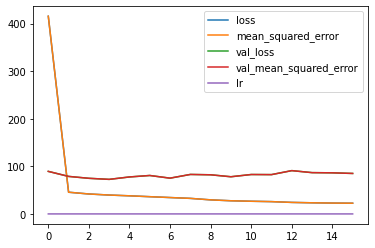

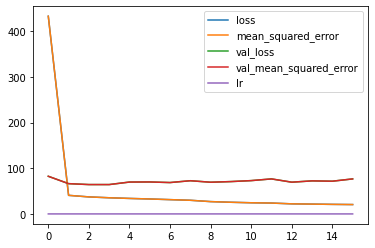

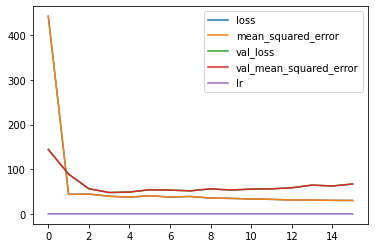

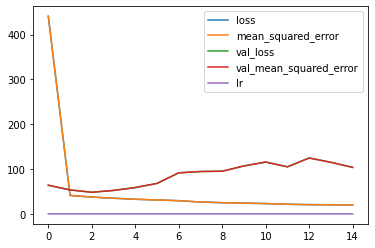

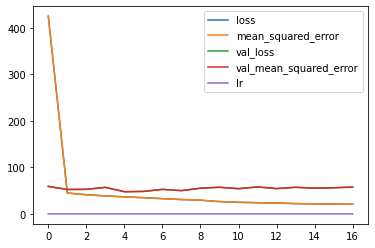

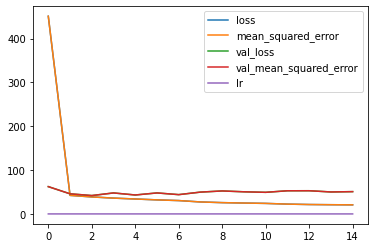

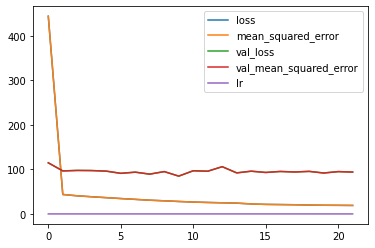

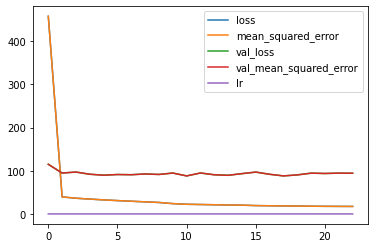

In [35]:
%%time
import time
import datetime

n_features_loc = 200# n_features # Found to be local max for pca on full Y (leaky)
# 0.17980, 66.123 r2_score,mean_squared_error oof_private_like Full sample 


X = df_X.iloc[:,1:n_features_loc].values

flag_train_on_full_data4submit = False
flag_save_predictions_on_each_sub_fold = False
flag_calculate_and_save_predictions_for_test_public_like = False


dict_model_results = {}

fold = 0
Y = dict_df_Y_reduced[fold].values
print('X.shape:', X.shape,'Y.shape:', dict_df_Y_reduced[0].shape)    
#print(dict_df_Y_reduced.keys() )

Y_pred_oof_private_like = np.zeros_like(Y)
if flag_calculate_and_save_predictions_for_test_public_like:
    Y_pred_oof_public_like = np.zeros_like(Y) # FEMALE is always in train - thus we have no predictions for female donor for that test part

n_submit_samples = X.shape[0] - Y.shape[0] # Multiome 161877 - 105942 = 55935;  CITEseq: 119651-70988 = 48663  
Y_pred_submission_Kaggle_way = np.zeros( (n_submit_samples , Y.shape[1]) )  # Way 2 (Kaggle way) - average predictions of models on each fold
if flag_train_on_full_data4submit: 
    Y_pred_submission_classical_way = np.zeros( (n_submit_samples , Y.shape[1]) )  # Way 1 (Classical way) - retrain model on the whole data

t0 = time.time();datetime_object = datetime.datetime.now()
df_stat_foldwise = pd.DataFrame()
print('Starts. ', datetime_object, 'X.shape, Y.shape:',  X.shape, dict_df_Y_reduced[0].shape,'n_submit_samples', n_submit_samples )
for fold, indices_tuple  in enumerate( list_folds_indices ):
    t00 = time.time()
    Y = dict_df_Y_reduced[fold].values
    train_index = indices_tuple[0]
    val_index = indices_tuple[1]
    
    ###### my model
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=0)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(best_hp, X.shape[1], Y.shape[1])
    

    history = model.fit(X[train_index],
                        Y[train_index], 
                        validation_data=(X[val_index], Y[val_index]), 
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
#                         verbose=VERBOSE,
                        shuffle=True,
                        callbacks=callbacks)
    
        
    model.save(f"resnet_model_100pca{str(fold)}")
    ! cp -rf "resnet2_model_"$fold /content/gdrive/MyDrive/kaggle/resnet_multiome
    #########
#     model.fit(X[train_index], Y[train_index])
    if verbose >= 100:
        print('fold:',fold, 'Train time:%.2f'%(time.time()-t00 ), 'X_train.shape:',X[train_index].shape )

    # Calculate predictions for test-private-like
    i_loc = 1
    indices_loc = indices_tuple[i_loc] # Private-like test
    y_pred = model.predict( X[indices_loc ])
    Y_pred_oof_private_like[indices_loc ] += y_pred * 0.5   # 0.5 - comes from the fact that our "quasi-folds" have intersection OOF parts - which correspond to "DAYs"
    if flag_save_predictions_on_each_sub_fold:
        dict_model_results['Pred_fold'+str(fold)+'_part'+str(i_loc)] = y_pred
    r2_loc, mse_loc = r2_score(Y[indices_loc], y_pred), mean_squared_error(Y[indices_loc], y_pred)
    df_stat_foldwise.loc[fold,'r2'] = r2_loc; df_stat_foldwise.loc[fold,'mse'] = mse_loc; 
    if verbose >= 100:
        print('%.3f, %.2f'%(r2_loc, mse_loc),  'r2_score,mean_squared_error oof_private_like: ',  'fold:',fold, )

    if (flag_save_predictions_on_each_sub_fold) or ( flag_calculate_and_save_predictions_for_test_public_like):
        # Calculate predictions for test-public-like
        i_loc = 2
        indices_loc = indices_tuple[i_loc] # Public-like test  # FEMALE is always in train - thus we have no predictions for female donor for that test part
        y_pred = model.predict( X[indices_loc ])
        if flag_calculate_and_save_predictions_for_test_public_like:
            Y_pred_oof_public_like[indices_loc ] += y_pred * (1/3) # 0.5 - comes from the fact that our "quasi-folds" have intersection OOF parts
                                                # If we THREE DAYs we should put  1/(3-1) = 1/2
                                                # If we have 4 days we should put 1/(4-1) = 1/3

        if flag_save_predictions_on_each_sub_fold:
            dict_model_results['Pred_fold'+str(fold)+'_part'+str(i_loc)] = y_pred

    if flag_save_predictions_on_each_sub_fold:
        # Save train predictions in case some deep analysis will be done 
        i_loc = 0  
        indices_loc = indices_tuple[i_loc] # Public-like test  # FEMALE is always in train - thus we have no predictions for female donor for that test part
        y_pred = model.predict( X[indices_loc ])
        dict_model_results['Pred_fold'+str(fold)+'_part'+str(i_loc)] = y_pred

    # Prepare submission data in way 2 - "Kaggle way"
    Y_pred_submission_Kaggle_way += model.predict( X[105942:,: ])   # Way 2 (Kaggle way) - average predictions of models on each fold   

    if verbose >= 100:
        print('Finished fold:',fold, 'Train&Inference time:%.2f'%(time.time()-t00 ), 'X_train.shape:',X[train_index].shape )
        
    history = history.history
    pd.DataFrame(history).plot()


Y_pred_submission_Kaggle_way /= (1+fold)  # Do not forget to average  predictions from all folds 

if flag_train_on_full_data4submit: 
    model.fit(X[:105942,:], Y) # Way 1 (Classical way) - retrain model on the whole data
    Y_pred_submission_classical_way = model.predict( X[70988:,: ])   

dict_model_results['Time'] = time.time() - t0
dict_model_results['list_folds_indices'] = list_folds_indices[:(fold+1)]
dict_model_results['Y_pred_oof_private_like'] = Y_pred_oof_private_like
if flag_calculate_and_save_predictions_for_test_public_like:
    dict_model_results['Y_pred_oof_public_like'] = Y_pred_oof_public_like
if flag_train_on_full_data4submit: 
    dict_model_results['Y_pred_submission_classical_way'] = Y_pred_submission_classical_way
dict_model_results['Y_pred_submission_Kaggle_way'] = Y_pred_submission_Kaggle_way

display(df_stat_foldwise)
display(df_stat_foldwise.describe())

if verbose >= 10:
    print('X.shape, Y.shape:',X.shape, Y.shape)
    print('Finished. Folds:',fold+1, 'Time:%.2f'%(time.time()-t0), 'Y_pred_oof_private_like.shape:',Y_pred_oof_private_like.shape,
         'Y_pred_submission_Kaggle_way.shape:',Y_pred_submission_Kaggle_way.shape )  
    print( datetime.datetime.now() )
if verbose >= 10:
    print()
    print('OOF scores:')
    print('%.5f, %.3f'%(r2_score(Y_reduced_oof_true_private_like, Y_pred_oof_private_like), mean_squared_error(Y_reduced_oof_true_private_like, Y_pred_oof_private_like)),  'r2_score,mean_squared_error oof_private_like Full sample ')#,  'fold:',fold, )
    print()

In [28]:
!cp -r /content/resnet_model_100pca0 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca1 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca2 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca3 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca4 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca5 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca6 /content/gdrive/MyDrive/kaggle/resnet_multiome
!cp -r /content/resnet_model_100pca7 /content/gdrive/MyDrive/kaggle/resnet_multiome

NameError: ignored

In [29]:
%%time
print(t.shape, Y_pred_oof_private_like.shape)
print('%.6f'%( mean_squared_error(df_train_y.values, t)),  'mean_squared_error oof_private_like Full sample ')#,  'fold:',fold, )


NameError: ignored

In [30]:
%%time
print(t.shape, Y_pred_oof_private_like.shape)
print('%.5f'%(r2_score(df_train_y.values, t)),  'r2_score,mean_squared_error oof_private_like Full sample ')#,  'fold:',fold, )


NameError: ignored

In [31]:
import gc
del t 
gc.collect()

NameError: ignored

In [ ]:


# 40
# 0.04339 r2_score,mean_squared_error oof_private_like Full sample 
# 2.061932 mean_squared_error oof_private_like Full sample 

# 45 
# 0.04337 r2_score
# 2.061931 mean_squared_error 

# 35
# 0.04331  2.062125 

# (105942, 23418) (105942, 30)
# 0.04320, 2.062 r2_score,mean_squared_error oof_private_like Full sample 

# (105942, 23418) (105942, 50)
# 0.04336, 2.061977  r2_score,mean_squared_error oof_private_like Full sample 

# 70
#0.04332 r2_score,mean_squared_error oof_private_like Full sample 
#2.062125 mean_squared_error oof_private_like Full sample 

# 80 - error increases 
# 2.062156 mean_squared_error oof_private_like Full sample 
# 0.04331 r2_score,mean_squared_error oof_private_like Full sample 

# (105942, 23418) (105942, 60)
# 0.04333, 2.062068 r2_score,mean_squared_error oof_private_like Full sample 
# CPU times: user 53.5 s, sys: 3.54 s, total: 57 s
# Wall time: 57.2 s
    

# 100 components of Y truncSVD 
#0.04330, 2.062 r2_score,mean_squared_error oof_private_like Full sample 

# (105942, 23418) (105942, 200)
# 0.04328, 2.062 r2_score,mean_squared_error oof_private_like Full sample 

In [ ]:

# Should NOT look on r2 on reduced space of Y. 
# Just 1: 
# 0.30065, 978.268 r2_score,mean_squared_error oof_private_like Full sample 

# 40
# 0.22919, 80.229 r2_score,mean_squared_error oof_private_like Full sample 

# 50 out of 300
# 0.18133, 66.407 r2_score,mean_squared_error oof_private_like Full sample 


# 60 out of 300 TruncSVD
# 0.14742, 56.953 r2_score,mean_squared_error oof_private_like Full sample 

# TruncSVD 50: 
#     With Ridge with score on reduced Y seems the following params are good: 
#     n_features_loc = 110# n_features # Found to be local max for pca on full Y (leaky)
#     # 0.17980, 66.123 r2_score,mean_squared_error oof_private_like Full sample 


In [ ]:
print(datetime.datetime.now())

print('%.1f seconds = %.1f minutes =  %.1f hours,  passed total '%((time.time()-t0start),(time.time()-t0start)/60,(time.time()-t0start)/3600) )